Installation of Required Libraries

In [1]:
!pip install shap optuna deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 59.7 MB/s eta 0:00:00


Import Modules

In [2]:
import shap.explainers._deep.deep_utils as deep_utils
deep_utils.TOLERANCE = 100.0   # way above your observed ~1.7 max diff
import shap
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_cosine_schedule_with_warmup
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.optim import AdamW
from optuna.pruners import MedianPruner
from math import sqrt
from rdkit import Chem

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


Define Dataset Class

In [66]:
#Mount Google Drive to access files in Colab
from google.colab import drive
drive.mount('/content/drive')
# Specify the path to dataset CSV file in Google Drive
file_path = '/content/drive/MyDrive/LLM/df_cattle_with_smiles.csv'
# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,CitationNumber,Long-acting,Drug,Analyte,Route,Matrix,Dose,LambdaZHl,CAS,PubChemCID,SMILES
0,9014781,NaN,1-Methy-2-pyrrolidone,1-Methy-2-pyrrolidone,Intramuscular,Fat,41.32,192.00,872-50-4,13387,CN1CCCC1=O
1,9014781,NaN,1-Methy-2-pyrrolidone,1-Methy-2-pyrrolidone,Intramuscular,Kidney,41.32,92.20,872-50-4,13387,CN1CCCC1=O
2,9014781,NaN,1-Methy-2-pyrrolidone,1-Methy-2-pyrrolidone,Intramuscular,Liver,41.32,111.80,872-50-4,13387,CN1CCCC1=O
3,9014781,NaN,1-Methy-2-pyrrolidone,1-Methy-2-pyrrolidone,Intramuscular,Muscle,41.32,101.10,872-50-4,13387,CN1CCCC1=O
4,9014314,NaN,2-Pyrrolidone,2-Pyrrolidone,Intramuscular,Milk,40.00,8.00,616-45-5,12025,C1CC(=O)NC1
...,...,...,...,...,...,...,...,...,...,...,...
1416,9014795,NaN,sulfadimethoxine,Sulfadimethoxine (acetyl metabolite),Intravenous,Liver,27.50,17.57,122-11-2,5323,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC
1417,9016095,NaN,sulfadimethoxine,sulfadimethoxine,Intravenous,Serum,55.00,19.95,122-11-2,5323,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC
1418,9016095,NaN,sulfadimethoxine,sulfadimethoxine,Intravenous,Serum,55.00,19.95,122-11-2,5323,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC
1419,9015559,NaN,sulfadimethoxine,sulfadimethoxine,Oral,Serum,25.00,15.30,122-11-2,5323,COC1=NC(=NC(=C1)NS(=O)(=O)C2=CC=C(C=C2)N)OC


In [67]:
group_cols = [c for c in df.columns if c != 'LambdaZHl']

df = (
    df
    .sort_values('LambdaZHl', ascending=False)
    .drop_duplicates(subset=group_cols, keep='first')
    .reset_index(drop=True)
)

df = df.dropna(subset=['LambdaZHl', 'SMILES', 'Route', 'Matrix'])

df

,CitationNumber,Long-acting,Drug,Analyte,Route,Matrix,Dose,LambdaZHl,CAS,PubChemCID,SMILES
0,9015577,NaN,Fluazuron,Fluazuron,Subcutaneous,Kidney,1.5000,7936.380000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...
1,9015593,NaN,Imidocarb dipropionate,Imidocarb dipropionate,Subcutaneous,Fat,3.0000,2046.800000,55750-06-6,9983292,CCC(=O)O.CCC(=O)O.C1CN=C(N1)C2=CC(=CC=C2)NC(=O...
2,9015168,NaN,Fluazuron,Fluazuron,Subcutaneous,Plasma,1.0000,1872.000000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...
3,9015168,NaN,Fluazuron,Fluazuron,Cutaneous (topical),Plasma,1.0000,1764.000000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...
4,9015577,NaN,Fluazuron,Fluazuron,Cutaneous (topical),Fat,2.0000,1408.450000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...
...,...,...,...,...,...,...,...,...,...,...,...
688,9018415,NaN,Carbetocin,Carbetocin,Intravenous,Plasma,NaN,0.430000,37025-55-1,16681432,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(CSCCCC(=O)NC(C...
689,9001367,NaN,Penicillin G sodium,Penicillin G,Intramuscular,Serum,0.6732,0.353800,69-57-8,23668834,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)[O...
690,9015487,NaN,Carazolol,Carazolol,Intravenous,Serum,NaN,0.308395,57775-29-8,71739,CC(C)NCC(COC1=CC=CC2=C1C3=CC=CC=C3N2)O
691,9018461,NaN,Oxytocin,Oxytocin,Other,Plasma,NaN,0.261667,50-56-6,439302,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(CSSCC(C(=O)NC(...


In [68]:
# Data preprocessing

df['LambdaZHl'] = pd.to_numeric(df['LambdaZHl'], errors='coerce')

df = df[
    (~df['Route'].isin(['Oral-medicated water', 'Transdermal'])) &
    (~df['Matrix'].isin(['Ileum ultrafltrate','Exudate']))
]


df['LambdaZHl_log'] = np.log(df['LambdaZHl'] + 1e-6)

df

<ipython-input-68-8041b447ce3e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['LambdaZHl_log'] = np.log(df['LambdaZHl'] + 1e-6)


,CitationNumber,Long-acting,Drug,Analyte,Route,Matrix,Dose,LambdaZHl,CAS,PubChemCID,SMILES,LambdaZHl_log
0,9015577,NaN,Fluazuron,Fluazuron,Subcutaneous,Kidney,1.5000,7936.380000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...,8.979213
1,9015593,NaN,Imidocarb dipropionate,Imidocarb dipropionate,Subcutaneous,Fat,3.0000,2046.800000,55750-06-6,9983292,CCC(=O)O.CCC(=O)O.C1CN=C(N1)C2=CC(=CC=C2)NC(=O...,7.624033
2,9015168,NaN,Fluazuron,Fluazuron,Subcutaneous,Plasma,1.0000,1872.000000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...,7.534763
3,9015168,NaN,Fluazuron,Fluazuron,Cutaneous (topical),Plasma,1.0000,1764.000000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...,7.475339
4,9015577,NaN,Fluazuron,Fluazuron,Cutaneous (topical),Fat,2.0000,1408.450000,86811-58-7,65651,C1=CC(=C(C(=C1)F)C(=O)NC(=O)NC2=CC(=C(C=C2)Cl)...,7.250245
...,...,...,...,...,...,...,...,...,...,...,...,...
688,9018415,NaN,Carbetocin,Carbetocin,Intravenous,Plasma,NaN,0.430000,37025-55-1,16681432,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(CSCCCC(=O)NC(C...,-0.843968
689,9001367,NaN,Penicillin G sodium,Penicillin G,Intramuscular,Serum,0.6732,0.353800,69-57-8,23668834,CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)[O...,-1.039021
690,9015487,NaN,Carazolol,Carazolol,Intravenous,Serum,NaN,0.308395,57775-29-8,71739,CC(C)NCC(COC1=CC=CC2=C1C3=CC=CC=C3N2)O,-1.176371
691,9018461,NaN,Oxytocin,Oxytocin,Other,Plasma,NaN,0.261667,50-56-6,439302,CCC(C)C1C(=O)NC(C(=O)NC(C(=O)NC(CSSCC(C(=O)NC(...,-1.340680


In [65]:
# Split data with stratification

stratify_bins = pd.qcut(df['LambdaZHl_log'], q=5, labels=False)

train_df, test_df = train_test_split(df, test_size=0.33, stratify=stratify_bins, random_state=42)

train_df.reset_index(drop=True, inplace=True)

test_df.reset_index(drop=True, inplace=True)

In [6]:
# Label encoding

route_encoder = LabelEncoder()

matrix_encoder = LabelEncoder()

train_df['Route_enc'] = route_encoder.fit_transform(train_df['Route'])

train_df['Matrix_enc'] = matrix_encoder.fit_transform(train_df['Matrix'])

test_df['Route_enc'] = route_encoder.transform(test_df['Route'])

test_df['Matrix_enc'] = matrix_encoder.transform(test_df['Matrix'])

In [7]:
# Standardize targets

lambda_scaler = StandardScaler()

train_df['LambdaZHl_scaled'] = lambda_scaler.fit_transform(train_df[['LambdaZHl_log']])

test_df['LambdaZHl_scaled'] = lambda_scaler.transform(test_df[['LambdaZHl_log']])

In [8]:
# Enhanced SMILES tokenization with stereochemical awareness

tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-77M-MTR")

tokenizer.add_special_tokens({'additional_special_tokens': ['/', '\\', '@']})  # Add stereo tokens

max_length = 256

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/17.7k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/8.26k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/420 [00:00<?, ?B/s]

In [9]:
def make_stereo_indices(input_ids, tokenizer):
    """Map token IDs '/', '\\', '@' → 1,2,3; all else → 0."""
    slash_id     = tokenizer.convert_tokens_to_ids('/')
    backslash_id = tokenizer.convert_tokens_to_ids('\\')
    at_id        = tokenizer.convert_tokens_to_ids('@')
    si = torch.zeros_like(input_ids)
    si[input_ids == slash_id]     = 1
    si[input_ids == backslash_id] = 2
    si[input_ids == at_id]        = 3
    return si

In [10]:
def tokenize_smiles(df):

    return tokenizer(

        df['SMILES'].tolist(),

        padding='max_length',

        truncation=True,

        max_length=max_length,

        return_tensors='pt'

    )

In [11]:
train_encoded = tokenize_smiles(train_df)

test_encoded = tokenize_smiles(test_df)

In [12]:
# Dataset class

class ChemDataset(Dataset):

    def __init__(self, encodings, routes, matrices, labels):

        self.input_ids = encodings['input_ids']

        self.attention_mask = encodings['attention_mask']

        self.routes = routes

        self.matrices = matrices

        self.labels = labels



    def __len__(self):

        return len(self.labels)



    def __getitem__(self, idx):

        return {

            'input_ids': self.input_ids[idx],

            'attention_mask': self.attention_mask[idx],

            'route': torch.tensor(self.routes[idx], dtype=torch.long),

            'matrix': torch.tensor(self.matrices[idx], dtype=torch.long),

            'labels': torch.tensor(self.labels[idx], dtype=torch.float)

        }

In [45]:
def prepare_diverse_background(model_to_use, loader, num_samples=50): # Pass the model
    """Batch up to num_samples examples for SHAP’s background distribution."""
    model_to_use.eval() # Use the passed model
    device = next(model_to_use.parameters()).device # Use the passed model

    bg = {k: [] for k in ('input_ids','attention_mask','route','matrix')}
    count = 0
    for batch in loader:
        for k_batch_key in bg.keys(): # Iterate over keys expected in bg
            if k_batch_key in batch: # Check if key exists in the current batch
                bg[k_batch_key].append(batch[k_batch_key].to(device))

        # Update count based on input_ids added
        if 'input_ids' in batch:
            count += batch['input_ids'].shape[0]

        if count >= num_samples:
            break

    # Concatenate and slice
    try:
        bg_concatenated = {k_bg: torch.cat(v, dim=0)[:num_samples] for k_bg, v in bg.items() if v} # only concat if list is not empty
    except RuntimeError as e:
        print(f"Error during concatenation in prepare_diverse_background: {e}")
        print("Background dictionary content:")
        for k_bg, v_list in bg.items():
            print(f"  {k_bg}: {[t.shape for t in v_list if hasattr(t, 'shape')]}")
        raise # Re-raise the error after printing debug info

    # Ensure all expected keys are present before returning, pad if necessary or error
    # This part depends on what analyze_with_shap strictly expects.
    # For now, assuming it handles missing keys gracefully or they are always present.
    return (bg_concatenated.get('input_ids'),
            bg_concatenated.get('attention_mask'),
            bg_concatenated.get('route'),
            bg_concatenated.get('matrix'))

In [14]:
class EnhancedChemBERTa(nn.Module):
    # Added dropout_rate parameter
    def __init__(self, chemberta_path, num_routes, num_matrices, tokenizer, dropout_rate=0.2):
        super().__init__()
        self.tokenizer = tokenizer
        self.chemberta = AutoModel.from_pretrained(chemberta_path)
        self.chemberta.resize_token_embeddings(len(tokenizer)) # Assumes tokenizer already has added tokens

        # Extra embeddings (same as before)
        self.route_embed  = nn.Embedding(num_routes,   16)
        self.matrix_embed = nn.Embedding(num_matrices, 16)
        self.stereo_embed = nn.Embedding(4,  8)  # none, '/', '\', '@'

        # Attention pooling (same as before)
        self.attention = nn.Sequential(
            nn.Linear(self.chemberta.config.hidden_size, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Softmax(dim=1)
        )

        # --- Simplified MLP Regressor Head ---
        combined_dim = self.chemberta.config.hidden_size + 16 + 16 + 8 # Route + Matrix + Stereo embeds

        self.regressor = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.GELU(),
            nn.Dropout(dropout_rate), # Added dropout
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Dropout(dropout_rate), # Added dropout
            nn.Linear(256, 1)
        )

    class ResidualBlock(nn.Module):
        def __init__(self, dim):
            super().__init__()
            self.block = nn.Sequential(
                nn.Linear(dim, dim*2),
                nn.GLU(),
                nn.Dropout(0.2),
                nn.Linear(dim, dim)
            )
        def forward(self, x):
            return x + self.block(x)

    def forward(self,
                input_ids=None,
                attention_mask=None,
                route=None,
                matrix=None,
                inputs_embeds=None,
                stereo_indices=None): # Keep stereo_indices logic internal

        # Calculate stereo_indices if not provided (same as before)
        if stereo_indices is None and input_ids is not None:
            device = input_ids.device # Get device from input_ids
            slash_id     = self.tokenizer.convert_tokens_to_ids('/')
            backslash_id = self.tokenizer.convert_tokens_to_ids('\\')
            at_id        = self.tokenizer.convert_tokens_to_ids('@')
            stereo_indices = torch.zeros_like(input_ids, device=device) # Ensure device consistency
            stereo_indices[input_ids == slash_id]     = 1
            stereo_indices[input_ids == backslash_id] = 2
            stereo_indices[input_ids == at_id]        = 3
        elif stereo_indices is None and inputs_embeds is not None:
             raise ValueError("stereo_indices must be provided if input_ids is None")
        elif stereo_indices is not None:
             # Ensure provided stereo_indices are on the correct device if passed explicitly
             device = self.chemberta.device # Get device from model parameter
             stereo_indices = stereo_indices.to(device)


        # ChemBERTa forward pass (same as before)
        if inputs_embeds is not None:
            # Ensure attention_mask is on the same device as embeddings
            device = inputs_embeds.device
            attention_mask = attention_mask.to(device) if attention_mask is not None else None
            chem_output = self.chemberta(
                inputs_embeds=inputs_embeds,
                attention_mask=attention_mask
            ).last_hidden_state
        else:
            device = input_ids.device # Device from input_ids
            attention_mask = attention_mask.to(device) if attention_mask is not None else None
            chem_output = self.chemberta(
                input_ids=input_ids,
                attention_mask=attention_mask
            ).last_hidden_state

        # Attention pooling (same as before)
        attn_w  = self.attention(chem_output)
        chem_p  = torch.sum(chem_output * attn_w, dim=1)

        # Other embeddings (ensure tensors are on the correct device - chem_p's device)
        route_e  = self.route_embed(route.to(chem_p.device))
        matrix_e = self.matrix_embed(matrix.to(chem_p.device))
        # Ensure stereo_indices is LongTensor and on the correct device
        stereo_e = self.stereo_embed(stereo_indices.long().to(chem_p.device)).mean(dim=1)

        # Concatenate all features
        x = torch.cat([chem_p, route_e, matrix_e, stereo_e], dim=1)
        return self.regressor(x)

In [53]:
class DeepSHAPWrapper(nn.Module):
    def __init__(self, model): # model is EnhancedChemBERTa
        super().__init__()
        self.model = model

    def forward(self,
                chem_embeds: torch.Tensor,    # 1st argument
                attention_mask: torch.Tensor, # 2nd argument
                route_emb: torch.Tensor,      # 3rd argument
                matrix_emb: torch.Tensor,     # 4th argument
                stereo_emb: torch.Tensor      # 5th argument <<<< THIS MUST BE PRESENT
               ):
        # Your forward pass logic using these 5 arguments
        chem_out = self.model.chemberta(
            inputs_embeds=chem_embeds,
            attention_mask=attention_mask
        ).last_hidden_state
        attn_w = self.model.attention(chem_out)
        chem_pooled = torch.sum(chem_out * attn_w, dim=1)

        # Concatenate with the pre-computed stereo_emb
        x = torch.cat([chem_pooled, route_emb, matrix_emb, stereo_emb], dim=1) # Use stereo_emb
        return self.model.regressor(x)


In [16]:
# ——— insert after EnhancedChemBERTa
class EmbeddingWrapper(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.chemberta    = model.chemberta
        self.route_embed  = model.route_embed
        self.matrix_embed = model.matrix_embed
        self.attention    = model.attention
        self.regressor    = model.regressor

    def forward(self, inputs_embeds, attention_mask, route, matrix, stereo_indices):
        # 1) backbone from embeddings
        chem_output = self.chemberta(
            inputs_embeds=inputs_embeds,
            attention_mask=attention_mask.long()
        ).last_hidden_state  # [B, L, H]

        # 2) attention pooling
        attn_w      = self.attention(chem_output)       # [B, L, 1]
        chem_pooled = (chem_output * attn_w).sum(1)     # [B, H]

        # 3) metadata embeddings
        route_e     = self.route_embed(route.long())    # [B, E1]
        matrix_e    = self.matrix_embed(matrix.long())  # [B, E2]
        stereo_emb = self.stereo_embed(stereo_indices.long()).mean(dim=1)

        # 4) combine & predict
        combined = torch.cat([chem_pooled, route_e, matrix_e, stereo_emb], dim=1)
        return self.regressor(combined)                # [B,1]

In [17]:
# Training setup with augmentation

def train_epoch(model, loader, optimizer, criterion, scheduler):

    model.train()

    total_loss = 0

    for batch in loader:

        optimizer.zero_grad()

        inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

        labels = batch['labels'].to(device)



        outputs = model(**inputs)

        loss = criterion(outputs.squeeze(), labels)



        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()



        total_loss += loss.item()

    return total_loss / len(loader)



def evaluate_model(model, loader, criterion):

    model.eval()

    total_loss = 0

    all_preds = []

    all_labels = []

    with torch.no_grad():

        for batch in loader:

            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}

            labels = batch['labels'].to(device)

            outputs = model(**inputs)

            loss = criterion(outputs.squeeze(), labels)

            total_loss += loss.item()

            all_preds.extend(outputs.squeeze().cpu().numpy())

            all_labels.extend(labels.cpu().numpy())



    return {

        'loss': total_loss / len(loader),

        'mae': mean_absolute_error(all_labels, all_preds),

        'rmse': sqrt(mean_squared_error(all_labels, all_preds)),

        'r2': r2_score(all_labels, all_preds)

    }



In [18]:
from rdkit import Chem

def objective(trial):
    # hyperparameters
    config = {
    'epochs': 60,
    'batch_size': trial.suggest_categorical("batch_size", [16, 32, 64]),
    'bert_lr':    trial.suggest_float("bert_lr",    1.5e-5, 6e-5, log=True), # Previous best was ~3.25e-5
    'head_lr':    trial.suggest_float("head_lr",    1e-4, 7e-4, log=True),   # Previous best was ~3.19e-4

    # CRITICAL REVISION: Focus on lower weight_decay values
    'weight_decay': trial.suggest_float("weight_decay", 1e-7, 5e-5, log=True),

    # n_augment was good at 5. Keep a similar range, perhaps add more granularity.
    'n_augment': trial.suggest_categorical("n_augment", [0,1,5,10,20,50]), # Focus on non-zero, explore slightly higher
                                                                         # If '5' was consistently optimal, you could even fix it or narrow range further.

    # dropout_rate was good. Keep a similar range.
    'dropout_rate': trial.suggest_float("dropout_rate", 0.25, 0.55), # Previous best ~0.367. Shift range slightly.
}

    # 2) Train/Val split
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    train_idx, val_idx = next(kf.split(train_df))
    train_sub = train_df.iloc[train_idx].copy()
    val_sub   = train_df.iloc[val_idx]

    # Label original rows
    train_sub['Source'] = 'experimental'

    # 3) Augment SMILES
    aug_smiles = []
    for smi in train_sub['SMILES']:
        mol = Chem.MolFromSmiles(smi)
        if not mol:
            continue
        # generate n_augment random SMILES
        for _ in range(config['n_augment']):
            aug_smiles.append(
                Chem.MolToSmiles(mol, doRandom=True, canonical=False)
            )

    aug_df = train_sub.loc[train_sub.index.repeat(config['n_augment'])].copy()
    aug_df['SMILES'] = aug_smiles
    aug_df['Source']  = 'simulated'

    # combine & export for this trial
    train_aug = pd.concat([train_sub, aug_df], ignore_index=True)


    out_path = f"/content/drive/MyDrive/LLM/augmented_dataset_trial{trial.number}.csv"
    train_aug.to_csv(out_path, index=False)
    print("Wrote augmented data to", out_path)

    # 4) Tokenize and Dataset
    train_dataset = ChemDataset(
    tokenize_smiles(train_aug),
    train_aug['Route_enc'].values,
    train_aug['Matrix_enc'].values,
    train_aug['LambdaZHl_scaled'].values.astype(float),
)

    val_dataset = ChemDataset(
        tokenize_smiles(val_sub),
        val_sub['Route_enc'].values,
        val_sub['Matrix_enc'].values,
        val_sub['LambdaZHl_scaled'].values.astype(float),
    )

    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=config['batch_size'])

    # 5) Build model and setup training components
    model = EnhancedChemBERTa(
        "DeepChem/ChemBERTa-77M-MTR",
        num_routes=len(route_encoder.classes_),
        num_matrices=len(matrix_encoder.classes_),
        tokenizer=tokenizer,
        dropout_rate=config['dropout_rate'] # Pass suggested dropout rate
    ).to(device)

    optimizer = AdamW([
        {'params': model.chemberta.parameters(), 'lr': config['bert_lr']},
        {'params': list(model.route_embed.parameters()) +
                   list(model.matrix_embed.parameters()) +
                   list(model.stereo_embed.parameters()) +
                   list(model.attention.parameters()) +
                   list(model.regressor.parameters()), 'lr': config['head_lr']},
    ], weight_decay=config['weight_decay'])

    total_steps = len(train_loader) * config['epochs']
    scheduler = get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(0.1 * total_steps),
        num_training_steps=total_steps,
    )
    criterion = nn.HuberLoss()
    best_r2 = -np.inf

    # 6) Training loop with Optuna pruning
    for epoch in range(config['epochs']):
        train_epoch(model, train_loader, optimizer, criterion, scheduler)
        val_metrics = evaluate_model(model, val_loader, criterion)
        r2_val = val_metrics['r2']

        trial.report(r2_val, step=epoch)
        # Early stopping
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        best_r2 = max(best_r2, r2_val)

    return best_r2

In [19]:
study = optuna.create_study(direction="maximize", pruner=MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=100)
print("Tuning done.")
print("Best trial:", study.best_trial.params)

[I 2025-05-09 19:55:05,453] A new study created in memory with name: no-name-fa7fdbca-228a-42b5-adec-f826e282e343


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial0.csv


pytorch_model.bin:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/14.0M [00:00<?, ?B/s]

[I 2025-05-09 19:57:37,671] Trial 0 finished with value: 0.5150809493453202 and parameters: {'batch_size': 64, 'bert_lr': 5.724691320564472e-05, 'head_lr': 0.00041515063000070545, 'weight_decay': 1.070852656878833e-06, 'n_augment': 10, 'dropout_rate': 0.25905210688043184}. Best is trial 0 with value: 0.5150809493453202.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial1.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 19:59:55,412] Trial 1 finished with value: 0.5011258258999719 and parameters: {'batch_size': 64, 'bert_lr': 4.508829425522144e-05, 'head_lr': 0.00013912342852586657, 'weight_decay': 2.7733167691192933e-05, 'n_augment': 10, 'dropout_rate': 0.3451633585383347}. Best is trial 0 with value: 0.5150809493453202.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial2.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:01:20,021] Trial 2 finished with value: 0.49329945839002654 and parameters: {'batch_size': 32, 'bert_lr': 4.613525290425606e-05, 'head_lr': 0.00029487709417501835, 'weight_decay': 1.8864785003440677e-06, 'n_augment': 5, 'dropout_rate': 0.3040492451777238}. Best is trial 0 with value: 0.5150809493453202.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial3.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:01:46,726] Trial 3 finished with value: 0.3264050027888066 and parameters: {'batch_size': 64, 'bert_lr': 1.5458781136910953e-05, 'head_lr': 0.00022467911725595222, 'weight_decay': 3.5844328891816734e-06, 'n_augment': 1, 'dropout_rate': 0.44502974870380835}. Best is trial 0 with value: 0.5150809493453202.
Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial4.csv


[I 2025-05-09 20:02:07,209] Trial 4 finished with value: 0.43793099077344055 and parameters: {'batch_size': 16, 'bert_lr': 2.089784942775191e-05, 'head_lr': 0.00039104689508794445, 'weight_decay': 5.616352597126062e-06, 'n_augment': 0, 'dropout_rate': 0.45794874072252695}. Best is trial 0 with value: 0.5150809493453202.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial5.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:17:37,197] Trial 5 finished with value: 0.45155082215079656 and parameters: {'batch_size': 16, 'bert_lr': 1.6037991727948748e-05, 'head_lr': 0.00031907250084824986, 'weight_decay': 7.652150236866298e-06, 'n_augment': 50, 'dropout_rate': 0.4780757826965311}. Best is trial 0 with value: 0.5150809493453202.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial6.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:17:39,436] Trial 6 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial7.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:21:02,517] Trial 7 finished with value: 0.46550377822947575 and parameters: {'batch_size': 16, 'bert_lr': 2.5070777514901853e-05, 'head_lr': 0.00028039482808741683, 'weight_decay': 3.984695192268688e-06, 'n_augment': 10, 'dropout_rate': 0.5384360435452665}. Best is trial 0 with value: 0.5150809493453202.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial8.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:21:26,962] Trial 8 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial9.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:21:30,232] Trial 9 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial10.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:25:50,965] Trial 10 finished with value: 0.5364662252547814 and parameters: {'batch_size': 64, 'bert_lr': 5.352595716887972e-05, 'head_lr': 0.0006898879044521994, 'weight_decay': 1.525403812840224e-07, 'n_augment': 20, 'dropout_rate': 0.2594648482128844}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial11.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:30:11,675] Trial 11 finished with value: 0.5070198184097113 and parameters: {'batch_size': 64, 'bert_lr': 5.792511624064453e-05, 'head_lr': 0.0006987002447197504, 'weight_decay': 1.2300499986993214e-07, 'n_augment': 20, 'dropout_rate': 0.2525122486720928}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial12.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:34:34,316] Trial 12 finished with value: 0.47998991688860926 and parameters: {'batch_size': 64, 'bert_lr': 5.900951051517262e-05, 'head_lr': 0.0006639674454914003, 'weight_decay': 1.8525943115629193e-07, 'n_augment': 20, 'dropout_rate': 0.25214309594074713}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial13.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:38:55,269] Trial 13 finished with value: 0.5236585998185573 and parameters: {'batch_size': 64, 'bert_lr': 3.6538888934201715e-05, 'head_lr': 0.00048124361770537737, 'weight_decay': 4.2759280340622036e-07, 'n_augment': 20, 'dropout_rate': 0.2990500787266399}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial14.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:43:15,948] Trial 14 finished with value: 0.5025494869219884 and parameters: {'batch_size': 64, 'bert_lr': 3.507818997028118e-05, 'head_lr': 0.0005421551218831483, 'weight_decay': 3.193976482539452e-07, 'n_augment': 20, 'dropout_rate': 0.3101022935388623}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial15.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:47:36,369] Trial 15 finished with value: 0.5148578134888081 and parameters: {'batch_size': 64, 'bert_lr': 3.3977913546763306e-05, 'head_lr': 0.0004914937688038084, 'weight_decay': 4.421023814563535e-07, 'n_augment': 20, 'dropout_rate': 0.297214348060439}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial16.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:49:09,097] Trial 16 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial17.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:49:13,130] Trial 17 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial18.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 20:59:44,013] Trial 18 finished with value: 0.5137992876921178 and parameters: {'batch_size': 64, 'bert_lr': 4.9884840754330724e-05, 'head_lr': 0.0006035863900220966, 'weight_decay': 2.29862060350111e-07, 'n_augment': 50, 'dropout_rate': 0.3498315455089126}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial19.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:01:08,701] Trial 19 finished with value: 0.5003239975803938 and parameters: {'batch_size': 32, 'bert_lr': 3.1536229097802365e-05, 'head_lr': 0.0004717525878846956, 'weight_decay': 6.340092472074078e-07, 'n_augment': 5, 'dropout_rate': 0.279741378127048}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial20.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:01:36,963] Trial 20 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial21.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:03:54,843] Trial 21 finished with value: 0.5063765772011917 and parameters: {'batch_size': 64, 'bert_lr': 5.39261344282273e-05, 'head_lr': 0.00038760228041492156, 'weight_decay': 7.772629712542647e-07, 'n_augment': 10, 'dropout_rate': 0.27003564511998984}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial22.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:04:27,540] Trial 22 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial23.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:06:45,709] Trial 23 finished with value: 0.5362489120223727 and parameters: {'batch_size': 64, 'bert_lr': 4.180194107332032e-05, 'head_lr': 0.00037264353391493356, 'weight_decay': 6.81583619409286e-07, 'n_augment': 10, 'dropout_rate': 0.27317061547134647}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial24.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:11:06,408] Trial 24 finished with value: 0.48021436729815437 and parameters: {'batch_size': 64, 'bert_lr': 4.0884440866535746e-05, 'head_lr': 0.0003516266066735631, 'weight_decay': 4.1909543997113594e-07, 'n_augment': 20, 'dropout_rate': 0.28029324877464507}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial25.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:11:32,951] Trial 25 finished with value: 0.48443093694286354 and parameters: {'batch_size': 64, 'bert_lr': 3.624584354672547e-05, 'head_lr': 0.0005691397550679087, 'weight_decay': 1.5206550051235593e-07, 'n_augment': 1, 'dropout_rate': 0.3697862449312929}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial26.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:22:03,265] Trial 26 finished with value: 0.508890577534842 and parameters: {'batch_size': 64, 'bert_lr': 3.0093685881145578e-05, 'head_lr': 0.0002475488789607689, 'weight_decay': 2.994456333392153e-07, 'n_augment': 50, 'dropout_rate': 0.3232863064524788}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial27.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:23:19,245] Trial 27 finished with value: 0.48517089496000343 and parameters: {'batch_size': 64, 'bert_lr': 4.2305102779293054e-05, 'head_lr': 0.0005063620582672698, 'weight_decay': 8.314348292244014e-07, 'n_augment': 5, 'dropout_rate': 0.2784074440852825}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial28.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:25:53,639] Trial 28 finished with value: 0.49024732525661185 and parameters: {'batch_size': 32, 'bert_lr': 4.961362920382191e-05, 'head_lr': 0.0006257748700372786, 'weight_decay': 6.315659498282577e-07, 'n_augment': 10, 'dropout_rate': 0.32341071036922664}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial29.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:29:16,969] Trial 29 finished with value: 0.48827755714480725 and parameters: {'batch_size': 16, 'bert_lr': 3.2777575712358714e-05, 'head_lr': 0.0003687906033815048, 'weight_decay': 1.3439172187990974e-06, 'n_augment': 10, 'dropout_rate': 0.25237939415379074}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial30.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:29:45,467] Trial 30 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial31.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:30:03,468] Trial 31 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial32.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:32:21,523] Trial 32 finished with value: 0.5166642913592336 and parameters: {'batch_size': 64, 'bert_lr': 5.16158113497528e-05, 'head_lr': 0.0005113633540174537, 'weight_decay': 1.0294734645286239e-06, 'n_augment': 10, 'dropout_rate': 0.30370933811903783}. Best is trial 10 with value: 0.5364662252547814.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial33.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:32:36,673] Trial 33 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial34.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:34:54,859] Trial 34 finished with value: 0.5420681662489213 and parameters: {'batch_size': 64, 'bert_lr': 4.559534429873704e-05, 'head_lr': 0.0006970399666142409, 'weight_decay': 9.434108979466207e-07, 'n_augment': 10, 'dropout_rate': 0.34362743593939343}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial35.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:37:12,716] Trial 35 finished with value: 0.5355852734869642 and parameters: {'batch_size': 64, 'bert_lr': 4.481252926844257e-05, 'head_lr': 0.0006912233635320495, 'weight_decay': 3.8044772562288025e-05, 'n_augment': 10, 'dropout_rate': 0.34742613820068236}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial36.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:39:31,100] Trial 36 finished with value: 0.526044009069622 and parameters: {'batch_size': 64, 'bert_lr': 4.616923268610394e-05, 'head_lr': 0.0006423344645640665, 'weight_decay': 3.1692264733450406e-05, 'n_augment': 10, 'dropout_rate': 0.430514277522949}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial37.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:39:47,857] Trial 37 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial38.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:40:09,483] Trial 38 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial39.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:40:11,446] Trial 39 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial40.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:40:20,204] Trial 40 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial41.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:42:37,933] Trial 41 finished with value: 0.4872157287193013 and parameters: {'batch_size': 64, 'bert_lr': 4.606539184566125e-05, 'head_lr': 0.0006025289751254609, 'weight_decay': 4.22167873371846e-05, 'n_augment': 10, 'dropout_rate': 0.4300175242306676}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial42.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:42:53,114] Trial 42 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial43.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:43:08,478] Trial 43 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial44.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:46:30,933] Trial 44 finished with value: 0.48006233540957555 and parameters: {'batch_size': 16, 'bert_lr': 4.8227477395713744e-05, 'head_lr': 0.0005749138310288568, 'weight_decay': 7.605823807586602e-06, 'n_augment': 10, 'dropout_rate': 0.44076327400358045}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial45.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:48:48,931] Trial 45 finished with value: 0.5243064695713175 and parameters: {'batch_size': 64, 'bert_lr': 5.911287514573995e-05, 'head_lr': 0.0006464383838723323, 'weight_decay': 2.8626030431933625e-05, 'n_augment': 10, 'dropout_rate': 0.41384617783084154}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial46.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:48:52,681] Trial 46 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial47.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:48:54,655] Trial 47 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial48.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:51:12,502] Trial 48 finished with value: 0.517954090922358 and parameters: {'batch_size': 64, 'bert_lr': 4.469609746459682e-05, 'head_lr': 0.0006996950178711609, 'weight_decay': 1.1592088096252915e-05, 'n_augment': 10, 'dropout_rate': 0.45754291061316144}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial49.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:52:20,347] Trial 49 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial50.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:52:42,103] Trial 50 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial51.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:52:57,428] Trial 51 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial52.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:53:12,770] Trial 52 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial53.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:55:30,573] Trial 53 finished with value: 0.4801979405130531 and parameters: {'batch_size': 64, 'bert_lr': 5.9558439206263794e-05, 'head_lr': 0.000539894579820321, 'weight_decay': 4.634950884102658e-06, 'n_augment': 10, 'dropout_rate': 0.389652882979984}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial54.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 21:57:49,643] Trial 54 finished with value: 0.47989338735249687 and parameters: {'batch_size': 64, 'bert_lr': 4.70835326920101e-05, 'head_lr': 0.0005906459049623877, 'weight_decay': 4.895490364268357e-05, 'n_augment': 10, 'dropout_rate': 0.42782309945635466}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial55.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:00:07,452] Trial 55 finished with value: 0.5263610804013469 and parameters: {'batch_size': 64, 'bert_lr': 5.5892525550373836e-05, 'head_lr': 0.0006509648212928782, 'weight_decay': 1.0948280417586467e-05, 'n_augment': 10, 'dropout_rate': 0.4378289689530224}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial56.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:00:10,989] Trial 56 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial57.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:00:13,133] Trial 57 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial58.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:00:31,014] Trial 58 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial59.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:11:00,728] Trial 59 finished with value: 0.47372698678403635 and parameters: {'batch_size': 64, 'bert_lr': 4.058036848556684e-05, 'head_lr': 0.0006511811902481533, 'weight_decay': 1.99322986259477e-05, 'n_augment': 50, 'dropout_rate': 0.29171240608209503}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial60.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:15:21,913] Trial 60 finished with value: 0.5314320800742174 and parameters: {'batch_size': 64, 'bert_lr': 5.655271778365368e-05, 'head_lr': 0.0004904749549630754, 'weight_decay': 3.2410744431900263e-06, 'n_augment': 20, 'dropout_rate': 0.26111062184682754}. Best is trial 34 with value: 0.5420681662489213.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial61.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:15:50,133] Trial 61 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial62.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:20:10,607] Trial 62 finished with value: 0.5485276743206907 and parameters: {'batch_size': 64, 'bert_lr': 5.659443458419127e-05, 'head_lr': 0.0003897086544226857, 'weight_decay': 2.8706993458726874e-06, 'n_augment': 20, 'dropout_rate': 0.263249800735397}. Best is trial 62 with value: 0.5485276743206907.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial63.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:24:31,342] Trial 63 finished with value: 0.49435213705862113 and parameters: {'batch_size': 64, 'bert_lr': 5.643738502403502e-05, 'head_lr': 0.0004378343768063549, 'weight_decay': 3.581414626418195e-06, 'n_augment': 20, 'dropout_rate': 0.27000578841466566}. Best is trial 62 with value: 0.5485276743206907.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial64.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:24:59,694] Trial 64 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial65.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:29:20,921] Trial 65 finished with value: 0.5493393377308919 and parameters: {'batch_size': 64, 'bert_lr': 5.063487220884219e-05, 'head_lr': 0.0003809449682041737, 'weight_decay': 1.253582254568276e-06, 'n_augment': 20, 'dropout_rate': 0.25751173532312127}. Best is trial 65 with value: 0.5493393377308919.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial66.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:33:42,088] Trial 66 finished with value: 0.5101075669344048 and parameters: {'batch_size': 64, 'bert_lr': 5.146136093517367e-05, 'head_lr': 0.00032570909580894474, 'weight_decay': 1.1761801285218896e-06, 'n_augment': 20, 'dropout_rate': 0.25684172141322636}. Best is trial 65 with value: 0.5493393377308919.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial67.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:38:02,943] Trial 67 finished with value: 0.469049007835342 and parameters: {'batch_size': 64, 'bert_lr': 4.9168426071769e-05, 'head_lr': 0.0003875738001953657, 'weight_decay': 1.7523998792088023e-06, 'n_augment': 20, 'dropout_rate': 0.25008813430917315}. Best is trial 65 with value: 0.5493393377308919.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial68.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:44:26,285] Trial 68 finished with value: 0.5387442993390006 and parameters: {'batch_size': 16, 'bert_lr': 4.345170626635838e-05, 'head_lr': 0.0003067455531984972, 'weight_decay': 8.685849098517589e-07, 'n_augment': 20, 'dropout_rate': 0.2663750038915279}. Best is trial 65 with value: 0.5493393377308919.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial69.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:50:49,220] Trial 69 finished with value: 0.552620466695384 and parameters: {'batch_size': 16, 'bert_lr': 4.4342998845073936e-05, 'head_lr': 0.00029609752610167627, 'weight_decay': 9.213690875846378e-07, 'n_augment': 20, 'dropout_rate': 0.31209012938922887}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial70.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:51:30,376] Trial 70 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial71.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:52:10,799] Trial 71 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial72.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:58:34,273] Trial 72 finished with value: 0.5430337436744146 and parameters: {'batch_size': 16, 'bert_lr': 3.485225715955487e-05, 'head_lr': 0.00035741816636335964, 'weight_decay': 1.3603512275822677e-06, 'n_augment': 20, 'dropout_rate': 0.2730673597391599}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial73.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 22:59:14,997] Trial 73 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial74.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:05:39,001] Trial 74 finished with value: 0.5016418208691641 and parameters: {'batch_size': 16, 'bert_lr': 3.274554818892943e-05, 'head_lr': 0.0003108678029264435, 'weight_decay': 1.2976596851041188e-06, 'n_augment': 20, 'dropout_rate': 0.2858230318783743}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial75.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:12:09,556] Trial 75 finished with value: 0.5189607625481976 and parameters: {'batch_size': 16, 'bert_lr': 2.688109818824775e-05, 'head_lr': 0.0002778734110371972, 'weight_decay': 7.238156897940055e-07, 'n_augment': 20, 'dropout_rate': 0.26239633664639905}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial76.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:18:34,078] Trial 76 finished with value: 0.48570129259986605 and parameters: {'batch_size': 16, 'bert_lr': 4.113309360221881e-05, 'head_lr': 0.0003666188759903294, 'weight_decay': 1.5686473595568736e-06, 'n_augment': 20, 'dropout_rate': 0.28438894426575767}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial77.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:19:14,950] Trial 77 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial78.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:19:55,461] Trial 78 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial79.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:26:20,113] Trial 79 finished with value: 0.484740490960225 and parameters: {'batch_size': 16, 'bert_lr': 4.705106817955555e-05, 'head_lr': 0.00040459242032733024, 'weight_decay': 5.150432351299697e-07, 'n_augment': 20, 'dropout_rate': 0.29039929763632183}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial80.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:32:43,663] Trial 80 finished with value: 0.47537964131501953 and parameters: {'batch_size': 16, 'bert_lr': 4.318879458886386e-05, 'head_lr': 0.00034127220590017993, 'weight_decay': 3.611378259083969e-07, 'n_augment': 20, 'dropout_rate': 0.26832714991278867}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial81.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:33:24,364] Trial 81 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial82.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:34:04,910] Trial 82 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial83.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:34:14,308] Trial 83 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial84.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:34:19,013] Trial 84 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial85.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:40:42,930] Trial 85 finished with value: 0.4816347487692886 and parameters: {'batch_size': 16, 'bert_lr': 4.790301482492303e-05, 'head_lr': 0.00010147869228210818, 'weight_decay': 2.5621572040677946e-07, 'n_augment': 20, 'dropout_rate': 0.2786781298737542}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial86.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:51:13,552] Trial 86 finished with value: 0.5220877579047978 and parameters: {'batch_size': 64, 'bert_lr': 4.5009112284832015e-05, 'head_lr': 0.00033118178165159555, 'weight_decay': 1.355442955823417e-06, 'n_augment': 50, 'dropout_rate': 0.29533848953881253}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial87.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:55:34,904] Trial 87 finished with value: 0.5192632039073061 and parameters: {'batch_size': 64, 'bert_lr': 5.3864577137638805e-05, 'head_lr': 0.0003034383076724686, 'weight_decay': 4.675569003415432e-07, 'n_augment': 20, 'dropout_rate': 0.3199672331343242}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial88.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-09 23:55:37,170] Trial 88 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial89.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:02:01,667] Trial 89 finished with value: 0.4844282316804246 and parameters: {'batch_size': 16, 'bert_lr': 5.0744233587072144e-05, 'head_lr': 0.0004081244174566763, 'weight_decay': 1.824430235605612e-07, 'n_augment': 20, 'dropout_rate': 0.34972698084042214}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial90.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:06:22,825] Trial 90 finished with value: 0.45842011771844937 and parameters: {'batch_size': 64, 'bert_lr': 3.917943797540574e-05, 'head_lr': 0.00020147030094994824, 'weight_decay': 6.631687498965856e-07, 'n_augment': 20, 'dropout_rate': 0.2541606613182605}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial91.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:10:43,574] Trial 91 finished with value: 0.5120777833860983 and parameters: {'batch_size': 64, 'bert_lr': 5.819334072998727e-05, 'head_lr': 0.0004929842715927997, 'weight_decay': 3.3385280595256167e-06, 'n_augment': 20, 'dropout_rate': 0.26211193997923243}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial92.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:15:05,168] Trial 92 finished with value: 0.46551149662106317 and parameters: {'batch_size': 64, 'bert_lr': 5.433150781687272e-05, 'head_lr': 0.00035207344899904525, 'weight_decay': 1.947625987613324e-06, 'n_augment': 20, 'dropout_rate': 0.2740199178667816}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial93.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:19:27,486] Trial 93 finished with value: 0.47738271814938904 and parameters: {'batch_size': 64, 'bert_lr': 4.839655635673711e-05, 'head_lr': 0.0004537354248266273, 'weight_decay': 1.523880219788804e-06, 'n_augment': 20, 'dropout_rate': 0.26358853478635225}. Best is trial 69 with value: 0.552620466695384.


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial94.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:19:56,215] Trial 94 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial95.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:20:28,776] Trial 95 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial96.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:20:46,119] Trial 96 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial97.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:20:54,772] Trial 97 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial98.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:20:58,047] Trial 98 pruned. 


Wrote augmented data to /content/drive/MyDrive/LLM/augmented_dataset_trial99.csv


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-05-10 00:23:16,219] Trial 99 finished with value: 0.45893198104366295 and parameters: {'batch_size': 64, 'bert_lr': 5.023951167447465e-05, 'head_lr': 0.0004823554308271439, 'weight_decay': 1.3138553272663144e-06, 'n_augment': 10, 'dropout_rate': 0.25823686919456973}. Best is trial 69 with value: 0.552620466695384.


Tuning done.
Best trial: {'batch_size': 16, 'bert_lr': 4.4342998845073936e-05, 'head_lr': 0.00029609752610167627, 'weight_decay': 9.213690875846378e-07, 'n_augment': 20, 'dropout_rate': 0.31209012938922887}


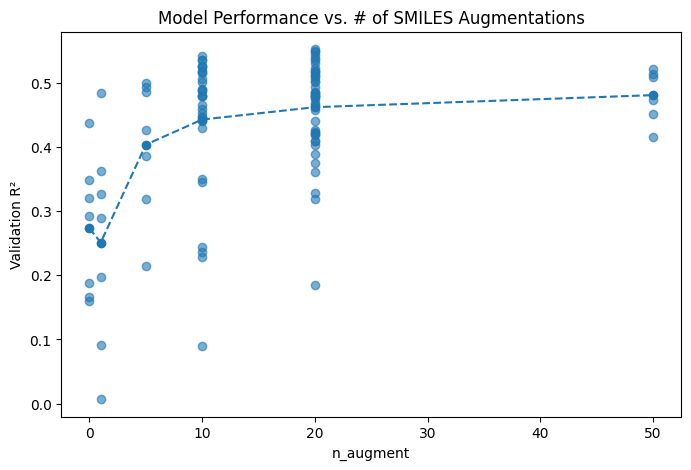

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# collect (n_augment, best_r2) for each finished trial
aug_vs_r2 = [(t.params['n_augment'], t.value)
             for t in study.trials if t.value is not None]

x_vals, y_vals = zip(*aug_vs_r2)

plt.figure(figsize=(8,5))
plt.scatter(x_vals, y_vals, alpha=0.6)
plt.xlabel("n_augment")
plt.ylabel("Validation R²")
plt.title("Model Performance vs. # of SMILES Augmentations")

# plot mean R² for each augmentation level
levels = sorted(set(x_vals))
mean_r2 = [np.mean([r2 for aug, r2 in aug_vs_r2 if aug == lvl])
           for lvl in levels]
plt.plot(levels, mean_r2, marker='o', linestyle='--')
plt.show()

In [20]:
best_config = study.best_trial.params

In [21]:
# --- Ensemble Configuration ---
N_ENSEMBLE_MODELS = 5  # Number of models in the ensemble (e.g., 3-5)
# Create a list of unique seeds for each ensemble member
ensemble_seeds = [best_config.get('random_seed', 42) + i * 10 for i in range(N_ENSEMBLE_MODELS)]

all_test_predictions_list = [] # To store predictions from each model

# --- Static parameters from best_config not related to random seeds ---
# These come from Optuna and are fixed for all ensemble members
epochs_total = best_config.get('epochs_total', 75) # Use .get for safety if not in optuna params
epochs_stage1 = best_config.get('epochs_stage1', 15)
epochs_stage2 = epochs_total - epochs_stage1
current_batch_size = best_config['batch_size']
current_n_augment = best_config['n_augment']
current_dropout_rate = best_config['dropout_rate']
current_bert_lr = best_config['bert_lr']
current_head_lr = best_config['head_lr']
current_weight_decay = best_config['weight_decay']


In [22]:
# --- Prepare Static Test DataLoader (can be done once) ---
# Test data and its tokenization do not change per ensemble member
test_dataset = ChemDataset(
    test_encoded, # Use pre-tokenized test set
    test_df['Route_enc'].values,
    test_df['Matrix_enc'].values,
    test_df['LambdaZHl_scaled'].values.astype(float)
)
test_loader = DataLoader(test_dataset, batch_size=current_batch_size) # Use best batch size


In [23]:
import numpy as np
import torch
import random
import pandas as pd
from sklearn.preprocessing import StandardScaler # If you re-scale per fold/run for some reason

for i_ensemble, current_seed in enumerate(ensemble_seeds):
    print(f"\n--- Training Ensemble Member {i_ensemble+1}/{N_ENSEMBLE_MODELS} with Seed {current_seed} ---")

    # --- Set Random Seeds for reproducibility of THIS ensemble member ---
    torch.manual_seed(current_seed)
    np.random.seed(current_seed)
    random.seed(current_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(current_seed)

    # --- Prepare full augmented training data (using best n_augment) ---
    print(f"Preparing full augmented dataset with n_augment={current_n_augment}...")
    # Start with a fresh copy of train_df for each ensemble member
    # train_df should be the original dataframe before augmentation
    full_member_train_df = train_df.copy()
    full_member_train_df['Source'] = 'experimental'

    aug_smiles_member = []
    if current_n_augment > 0:
        for smi in full_member_train_df['SMILES']:
            mol = Chem.MolFromSmiles(smi)
            if mol:
                # Optional: Chem.SanitizeMol(mol) here if you want to ensure augmented SMILES are valid
                for _ in range(current_n_augment):
                    aug_smiles_member.append(
                        Chem.MolToSmiles(mol, doRandom=True, canonical=False) # doRandom uses rdkit's internal RNG
                    )
        aug_df_member = full_member_train_df.loc[full_member_train_df.index.repeat(current_n_augment)].copy()
        aug_df_member['SMILES'] = aug_smiles_member
        aug_df_member['Source']  = 'simulated'
        full_aug_member_df = pd.concat([full_member_train_df, aug_df_member], ignore_index=True)
    else:
        full_aug_member_df = full_member_train_df

    print(f"Full augmented training set size for member {i_ensemble+1}: {len(full_aug_member_df)}")

    # Prepare final train dataloader for THIS ensemble member
    # Shuffling in DataLoader will be affected by the torch.manual_seed
    full_train_dataset_member = ChemDataset(
        tokenize_smiles(full_aug_member_df),
        full_aug_member_df['Route_enc'].values,
        full_aug_member_df['Matrix_enc'].values,
        full_aug_member_df['LambdaZHl_scaled'].values.astype(float)
    )
    full_train_loader_member = DataLoader(full_train_dataset_member, batch_size=current_batch_size, shuffle=True)


    # --- Initialize Model for THIS ensemble member ---
    # Weight initialization in the head will be affected by the seed
    print("Initializing model for ensemble member...")
    model_member = EnhancedChemBERTa(
        "DeepChem/ChemBERTa-77M-MTR",
        num_routes=len(route_encoder.classes_),
        num_matrices=len(matrix_encoder.classes_),
        tokenizer=tokenizer,
        dropout_rate=current_dropout_rate
    ).to(device)

    criterion_member = nn.HuberLoss()


--- Training Ensemble Member 1/5 with Seed 42 ---
Preparing full augmented dataset with n_augment=20...
Full augmented training set size for member 1: 9639
Initializing model for ensemble member...


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training Ensemble Member 2/5 with Seed 52 ---
Preparing full augmented dataset with n_augment=20...
Full augmented training set size for member 2: 9639
Initializing model for ensemble member...


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training Ensemble Member 3/5 with Seed 62 ---
Preparing full augmented dataset with n_augment=20...
Full augmented training set size for member 3: 9639
Initializing model for ensemble member...


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training Ensemble Member 4/5 with Seed 72 ---
Preparing full augmented dataset with n_augment=20...
Full augmented training set size for member 4: 9639
Initializing model for ensemble member...


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



--- Training Ensemble Member 5/5 with Seed 82 ---
Preparing full augmented dataset with n_augment=20...
Full augmented training set size for member 5: 9639
Initializing model for ensemble member...


Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-77M-MTR and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
    # --- Stage 1: Train Head Only ---
    print(f"\n--- Member {i_ensemble+1} - Stage 1: Training Head Only ({epochs_stage1} epochs) ---")
    for param in model_member.chemberta.parameters():
        param.requires_grad = False
    optimizer_stage1_member = AdamW([
        {'params': list(model_member.route_embed.parameters()) +
                   list(model_member.matrix_embed.parameters()) +
                   list(model_member.stereo_embed.parameters()) +
                   list(model_member.attention.parameters()) +
                   list(model_member.regressor.parameters()),
         'lr': current_head_lr, 'weight_decay': current_weight_decay}
    ])
    total_steps_s1_member = len(full_train_loader_member) * epochs_stage1
    scheduler_stage1_member = get_cosine_schedule_with_warmup(
        optimizer_stage1_member,
        num_warmup_steps=max(1, int(0.1 * total_steps_s1_member)),
        num_training_steps=max(1, total_steps_s1_member)
    )
    for epoch in range(epochs_stage1):
        train_loss = train_epoch(model_member, full_train_loader_member, optimizer_stage1_member, criterion_member, scheduler_stage1_member)
        print(f"Member {i_ensemble+1} - Stage 1 - Epoch {epoch+1}/{epochs_stage1} | Train Loss: {train_loss:.4f}")


--- Member 5 - Stage 1: Training Head Only (15 epochs) ---
Member 5 - Stage 1 - Epoch 1/15 | Train Loss: 0.2587
Member 5 - Stage 1 - Epoch 2/15 | Train Loss: 0.1324
Member 5 - Stage 1 - Epoch 3/15 | Train Loss: 0.0986
Member 5 - Stage 1 - Epoch 4/15 | Train Loss: 0.0828
Member 5 - Stage 1 - Epoch 5/15 | Train Loss: 0.0716
Member 5 - Stage 1 - Epoch 6/15 | Train Loss: 0.0638
Member 5 - Stage 1 - Epoch 7/15 | Train Loss: 0.0578
Member 5 - Stage 1 - Epoch 8/15 | Train Loss: 0.0523
Member 5 - Stage 1 - Epoch 9/15 | Train Loss: 0.0491
Member 5 - Stage 1 - Epoch 10/15 | Train Loss: 0.0465
Member 5 - Stage 1 - Epoch 11/15 | Train Loss: 0.0443
Member 5 - Stage 1 - Epoch 12/15 | Train Loss: 0.0413
Member 5 - Stage 1 - Epoch 13/15 | Train Loss: 0.0412
Member 5 - Stage 1 - Epoch 14/15 | Train Loss: 0.0398
Member 5 - Stage 1 - Epoch 15/15 | Train Loss: 0.0391


In [25]:
    # --- Stage 2: Fine-tune Full Model ---
    print(f"\n--- Member {i_ensemble+1} - Stage 2: Fine-tuning Full Model ({epochs_stage2} epochs) ---")
    for param in model_member.chemberta.parameters():
        param.requires_grad = True
    optimizer_stage2_member = AdamW([
        {'params': model_member.chemberta.parameters(), 'lr': current_bert_lr},
        {'params': list(model_member.route_embed.parameters()) +
                   list(model_member.matrix_embed.parameters()) +
                   list(model_member.stereo_embed.parameters()) +
                   list(model_member.attention.parameters()) +
                   list(model_member.regressor.parameters()),
         'lr': current_head_lr}
    ], weight_decay=current_weight_decay)
    total_steps_s2_member = len(full_train_loader_member) * epochs_stage2
    scheduler_stage2_member = get_cosine_schedule_with_warmup(
        optimizer_stage2_member,
        num_warmup_steps=max(1, int(0.1 * total_steps_s2_member)),
        num_training_steps=max(1, total_steps_s2_member)
    )
    for epoch in range(epochs_stage2):
        train_loss = train_epoch(model_member, full_train_loader_member, optimizer_stage2_member, criterion_member, scheduler_stage2_member)
        print(f"Member {i_ensemble+1} - Stage 2 - Epoch {epoch+1}/{epochs_stage2} | Train Loss: {train_loss:.4f}")

    # --- Get Predictions from THIS ensemble member on the Test Set ---
    model_member.eval()
    member_test_preds = []
    with torch.no_grad():
        for batch in test_loader: # Use the static test_loader
            inputs_test = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs_test = model_member(**inputs_test)
            member_test_preds.extend(outputs_test.squeeze().cpu().numpy())
    all_test_predictions_list.append(member_test_preds)
    print(f"Finished training and predicting for ensemble member {i_ensemble+1}.")
    # Optional: Evaluate and print metrics for this individual member
    # member_metrics = evaluate_model(model_member, test_loader, criterion_member)
    # print(f"Member {i_ensemble+1} Test R²: {member_metrics['r2']:.4f}")


--- Member 5 - Stage 2: Fine-tuning Full Model (60 epochs) ---
Member 5 - Stage 2 - Epoch 1/60 | Train Loss: 0.0403
Member 5 - Stage 2 - Epoch 2/60 | Train Loss: 0.0400
Member 5 - Stage 2 - Epoch 3/60 | Train Loss: 0.0396
Member 5 - Stage 2 - Epoch 4/60 | Train Loss: 0.0367
Member 5 - Stage 2 - Epoch 5/60 | Train Loss: 0.0341
Member 5 - Stage 2 - Epoch 6/60 | Train Loss: 0.0320
Member 5 - Stage 2 - Epoch 7/60 | Train Loss: 0.0280
Member 5 - Stage 2 - Epoch 8/60 | Train Loss: 0.0243
Member 5 - Stage 2 - Epoch 9/60 | Train Loss: 0.0217
Member 5 - Stage 2 - Epoch 10/60 | Train Loss: 0.0196
Member 5 - Stage 2 - Epoch 11/60 | Train Loss: 0.0179
Member 5 - Stage 2 - Epoch 12/60 | Train Loss: 0.0168
Member 5 - Stage 2 - Epoch 13/60 | Train Loss: 0.0152
Member 5 - Stage 2 - Epoch 14/60 | Train Loss: 0.0144
Member 5 - Stage 2 - Epoch 15/60 | Train Loss: 0.0142
Member 5 - Stage 2 - Epoch 16/60 | Train Loss: 0.0132
Member 5 - Stage 2 - Epoch 17/60 | Train Loss: 0.0129
Member 5 - Stage 2 - Epoch 

In [26]:
# --- Aggregate Ensemble Predictions ---
# 'all_test_predictions_list' is a list of lists; convert to a 2D numpy array
predictions_array = np.array(all_test_predictions_list) # Shape: (N_ENSEMBLE_MODELS, N_TEST_SAMPLES)
ensemble_final_predictions = np.mean(predictions_array, axis=0) # Average across models for each sample

# --- Evaluate Ensemble Performance ---
# Get true labels (scaled) from the test_df (once)
true_labels_scaled_test = test_df['LambdaZHl_scaled'].values

print("\n--- Final Ensemble Model Evaluation (on scaled values) ---")
ensemble_mae = mean_absolute_error(true_labels_scaled_test, ensemble_final_predictions)
ensemble_rmse = sqrt(mean_squared_error(true_labels_scaled_test, ensemble_final_predictions))
ensemble_r2 = r2_score(true_labels_scaled_test, ensemble_final_predictions)

print(f"Ensemble Test MAE: {ensemble_mae:.4f}")
print(f"Ensemble Test RMSE: {ensemble_rmse:.4f}")
print(f"Ensemble Test R²: {ensemble_r2:.4f}")


--- Final Ensemble Model Evaluation (on scaled values) ---
Ensemble Test MAE: 0.4223
Ensemble Test RMSE: 0.5559
Ensemble Test R²: 0.6870



--- Visualizing Ensemble Performance ---
R² calculated on original (inverse-transformed) scale for plot consistency: -2.0336


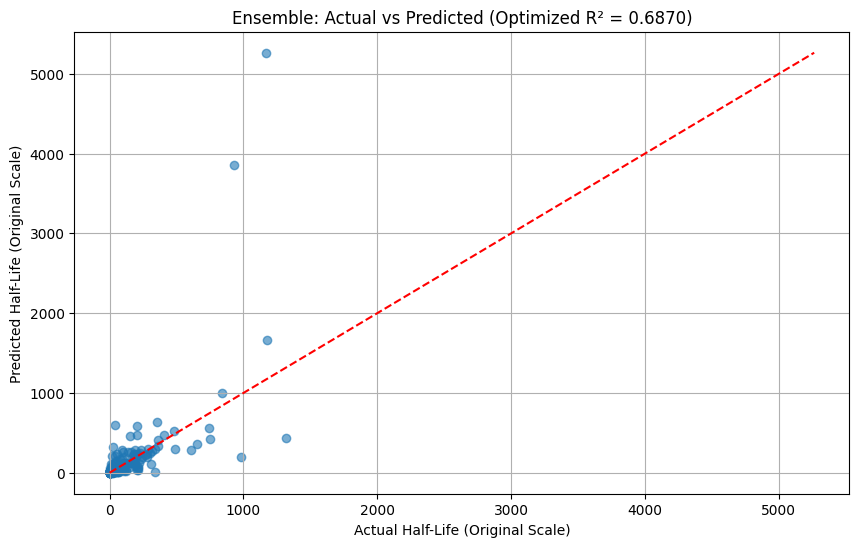

In [30]:
print("\n--- Visualizing Ensemble Performance ---")
def inverse_transform_for_plot(scaled_values_array):
    # Assuming lambda_scaler.inverse_transform expects a 2D array [n_samples, n_features]
    # and your scaled_values_array is 1D.
    if scaled_values_array.ndim == 1:
        scaled_values_array = scaled_values_array.reshape(-1, 1)

    # Inverse transform from scaled to log-scale
    log_transformed_values = lambda_scaler.inverse_transform(scaled_values_array)

    # Inverse log transform (exp) and subtract epsilon
    original_scale_values = np.exp(log_transformed_values.flatten()) - 1e-6
    return original_scale_values

# Check if lambda_scaler is defined
if 'lambda_scaler' not in locals() and 'lambda_scaler' not in globals():
    print("Error: lambda_scaler is not defined. Cannot perform inverse transform for plotting.")
else:
    preds_original_scale = inverse_transform_for_plot(ensemble_final_predictions)
    actuals_original_scale = inverse_transform_for_plot(true_labels_scaled_test)

    # --- Sanity Check: Calculate R² on original scale (optional, but good for consistency) ---
    # This R² might be slightly different from the R² on the scaled values due to the non-linear transform.
    # It's common practice to report metrics on the scale they were optimized (scaled)
    # but visualize on the original, interpretable scale.
    r2_on_original_scale = r2_score(actuals_original_scale, preds_original_scale)
    print(f"R² calculated on original (inverse-transformed) scale for plot consistency: {r2_on_original_scale:.4f}")


    plt.figure(figsize=(10, 6))
    plt.scatter(actuals_original_scale, preds_original_scale, alpha=0.6)

    # Plot y=x line based on the range of actuals_original_scale
    min_val = min(np.min(actuals_original_scale), np.min(preds_original_scale))
    max_val = max(np.max(actuals_original_scale), np.max(preds_original_scale))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    plt.xlabel('Actual Half-Life (Original Scale)')
    plt.ylabel('Predicted Half-Life (Original Scale)')
    # Use the ensemble_r2 calculated on the SCALED data for the title, as that's what your model optimized.
    # Or, if you prefer, use r2_on_original_scale. Be clear which one it is.
    plt.title(f'Ensemble: Actual vs Predicted (Optimized R² = {ensemble_r2:.4f})')
    plt.grid(True)
    plt.show()


--- Generating Residual Plot for Ensemble Predictions (Original Scale) ---


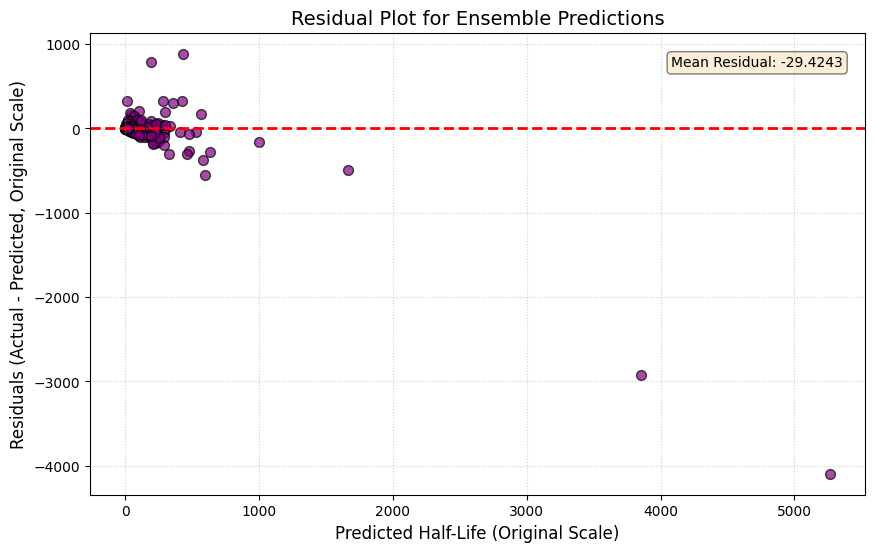

In [44]:
# <<< This code block assumes the previous visualization block has run >>>
# <<< and `preds_original_scale` and `actuals_original_scale` are defined >>>
# <<< and 'lambda_scaler' is available and correctly fitted if not already handled >>>

# Ensure preds_original_scale and actuals_original_scale exist from previous block
if 'preds_original_scale' in locals() and 'actuals_original_scale' in locals():

    print("\n--- Generating Residual Plot for Ensemble Predictions (Original Scale) ---")

    # Calculate residuals on the original, interpretable scale
    residuals_original_scale = actuals_original_scale - preds_original_scale

    plt.figure(figsize=(10, 6))
    plt.scatter(preds_original_scale, residuals_original_scale, alpha=0.7, color='purple', edgecolors='k', s=50) # Added edgecolors and size

    # Horizontal line at y=0 (perfect prediction)
    plt.axhline(0, color='red', linestyle='--', linewidth=2)

    plt.xlabel('Predicted Half-Life (Original Scale)', fontsize=12)
    plt.ylabel('Residuals (Actual - Predicted, Original Scale)', fontsize=12)
    plt.title('Residual Plot for Ensemble Predictions', fontsize=14)

    # Add a light grid for better readability
    plt.grid(True, linestyle=':', alpha=0.6) # Changed linestyle and alpha for subtlety

    # Optional: Add text indicating mean of residuals (should be close to 0 for unbiased model)
    mean_residual = np.mean(residuals_original_scale)
    plt.text(0.75, 0.95, f'Mean Residual: {mean_residual:.4f}',
             transform=plt.gca().transAxes, # Position relative to axes
             fontsize=10, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.3', fc='wheat', alpha=0.5))

    plt.show()

In [35]:
# Use your training loader as the SHAP background set
background_loader = full_train_loader_member

In [48]:
# REVISED analyze_with_shap function
def analyze_with_shap(model_to_explain, background_loader, test_loader, tokenizer,
                      test_df, num_background=50, num_test_samples=20):
    device = next(model_to_explain.parameters()).device
    wrapper_for_shap = DeepSHAPWrapper(model_to_explain).to(device)
    wrapper_for_shap.eval()

    print(f"Using device: {device} for SHAP analysis")
    print(f"Preparing background data with {num_background} samples...")

    try:
        bg_batch = next(iter(background_loader))
    except StopIteration:
        print("Error: background_loader is empty!")
        return None, None, None, None # Return None for all expected values

    actual_bg_samples = min(num_background, bg_batch['input_ids'].shape[0])
    if actual_bg_samples < num_background:
         print(f"Warning: Background batch only has {actual_bg_samples} samples, requested {num_background}.")

    bg_ids     = bg_batch['input_ids'][:actual_bg_samples].to(device)
    bg_mask    = bg_batch['attention_mask'][:actual_bg_samples].to(device)
    bg_route_i = bg_batch['route'][:actual_bg_samples].to(device)
    bg_mat_i   = bg_batch['matrix'][:actual_bg_samples].to(device)
    bg_stereo_i  = make_stereo_indices(bg_ids, tokenizer).to(device)

    with torch.no_grad():
        bg_chem_embeds = model_to_explain.chemberta.embeddings(bg_ids).float()
        bg_route_emb  = model_to_explain.route_embed(bg_route_i.long()).float()
        bg_mat_emb    = model_to_explain.matrix_embed(bg_mat_i.long()).float()
        # Ensure stereo_embed is also on the model_to_explain if EnhancedChemBERTa has it
        if hasattr(model_to_explain, 'stereo_embed'):
            bg_stereo_emb = model_to_explain.stereo_embed(bg_stereo_i.long()).mean(dim=1).float()
        else: # Fallback if stereo_embed is missing, though DeepSHAPWrapper expects it
            print("Warning: model_to_explain does not have stereo_embed. Using zeros for background stereo_emb.")
            # Determine the expected dimension for stereo_emb, e.g., 8 from your EnhancedChemBERTa
            stereo_emb_dim = 8 # Assuming it's 8 from your model definition
            bg_stereo_emb = torch.zeros(actual_bg_samples, stereo_emb_dim, device=device).float()


    background_shap_inputs = [
        bg_chem_embeds,
        bg_mask.float(),
        bg_route_emb,
        bg_mat_emb,
        bg_stereo_emb # Fifth element
    ]
    print("Background data prepared for SHAP.")

    try:
        explainer = shap.DeepExplainer(wrapper_for_shap, background_shap_inputs)
        print("SHAP DeepExplainer initialized.")
    except Exception as e:
        print(f"Error initializing SHAP DeepExplainer: {e}")
        for i, item in enumerate(background_shap_inputs):
            print(f"Background input {i} shape: {item.shape if hasattr(item, 'shape') else type(item)}")
        # Potentially return None or raise
        return None, None, None, None


    print(f"Preparing test data with up to {num_test_samples} samples...")
    try:
        test_batch_data = next(iter(test_loader))
    except StopIteration:
        print("Error: test_loader is empty!")
        return None, None, None, None

    actual_test_samples = min(num_test_samples, test_batch_data['input_ids'].shape[0])
    if actual_test_samples < num_test_samples:
        print(f"Warning: Test batch only has {actual_test_samples} samples, requested {num_test_samples}.")

    t_ids     = test_batch_data['input_ids'][:actual_test_samples].to(device)
    t_mask    = test_batch_data['attention_mask'][:actual_test_samples].to(device)
    t_route_i = test_batch_data['route'][:actual_test_samples].to(device)
    t_mat_i   = test_batch_data['matrix'][:actual_test_samples].to(device)
    t_stereo_i = make_stereo_indices(t_ids, tokenizer).to(device)

    with torch.no_grad():
        t_chem_embeds = model_to_explain.chemberta.embeddings(t_ids).float()
        t_route_emb  = model_to_explain.route_embed(t_route_i.long()).float()
        t_mat_emb    = model_to_explain.matrix_embed(t_mat_i.long()).float()
        if hasattr(model_to_explain, 'stereo_embed'):
            t_stereo_emb = model_to_explain.stereo_embed(t_stereo_i.long()).mean(dim=1).float() # Ensure .float()
        else:
            print("Warning: model_to_explain does not have stereo_embed. Using zeros for test stereo_emb.")
            stereo_emb_dim = 8 # Assuming it's 8
            t_stereo_emb = torch.zeros(actual_test_samples, stereo_emb_dim, device=device).float()


    # <<< REVISION START: Add t_stereo_emb to test_inputs >>>
    test_shap_inputs = [
        t_chem_embeds,
        t_mask.float(),
        t_route_emb,
        t_mat_emb,
        t_stereo_emb  # Add the fifth element here
    ]
    # <<< REVISION END >>>
    print("Test data prepared for SHAP.")

    try:
        shap_values_list = explainer.shap_values(test_shap_inputs, check_additivity=False)
        print("SHAP values computed.")
    except Exception as e:
        print(f"Error computing SHAP values: {e}")
        for i, item in enumerate(test_shap_inputs):
            print(f"Test input {i} shape: {item.shape if hasattr(item, 'shape') else type(item)}")
        return None, None, None, None # Return None on error

    if shap_values_list and shap_values_list[0] is not None:
        # Ensure shap_values_list[0] (SHAP for chem_embeds) is a NumPy array for .sum()
        shap_for_chem_embeds = shap_values_list[0]
        if isinstance(shap_for_chem_embeds, torch.Tensor):
            shap_for_chem_embeds = shap_for_chem_embeds.cpu().numpy()
        token_importance_scores = shap_for_chem_embeds.sum(axis=-1)
    else:
        print("Warning: SHAP values for chemical embeddings are missing or None.")
        token_importance_scores = np.array([])

    smiles_for_shap = test_df['SMILES'].tolist()[:actual_test_samples]
    return shap_values_list, test_shap_inputs, smiles_for_shap, token_importance_scores


In [54]:
# MAIN SHAP ANALYSIS EXECUTION
print("\n--- SHAP Analysis on the LAST TRAINED FOLD MODEL ---")

if 'model_member' in locals() or 'model_member' in globals(): # Variable holding the last trained model
    model_to_analyze_with_shap = model_member
    print(f"Using model from last trained ensemble member for SHAP.")

    if 'full_train_loader_member' in locals() or 'full_train_loader_member' in globals(): # Loader for that model's training
        background_loader_for_shap = full_train_loader_member
        print(f"Using its corresponding training loader as background for SHAP.")

        # Now call analyze_with_shap
        # Note: analyze_with_shap now returns a list of SHAP value arrays
        list_of_shap_values, analyzed_test_inputs, analyzed_test_smiles, analyzed_token_importances = analyze_with_shap(
            model_to_analyze_with_shap,
            background_loader_for_shap,
            test_loader,        # Your general test_loader
            tokenizer,
            test_df,            # test_df to get SMILES strings
            num_background=50,  # Number of background samples to use from background_loader
            num_test_samples=20 # Number of test samples to explain
        )

        if list_of_shap_values is not None:
            print("SHAP analysis completed successfully.")
            # --- Define feature_names based on the inputs to DeepSHAPWrapper ---
            # These correspond to bg_inputs / test_inputs in analyze_with_shap
            # Order: chem_embeds, attention_mask, route_emb, matrix_emb, stereo_emb
            feature_names_for_global_importance = [
                "SMILES Token Embeddings",
                "Attention Mask",
                "Route Embeddings",
                "Matrix Embeddings",
                "Stereo Embeddings"
            ]

            if len(feature_names_for_global_importance) != len(list_of_shap_values):
                print(f"Error/Warning: Mismatch between feature_names ({len(feature_names_for_global_importance)}) and returned SHAP value groups ({len(list_of_shap_values)}).")
                print("Please check the `DeepSHAPWrapper`'s forward method inputs and the `analyze_with_shap` function's `background_shap_inputs`/`test_shap_inputs` list structure.")
                # Fallback:
                # feature_names_for_global_importance = [f"Input Group {i+1}" for i in range(len(list_of_shap_values))]

            # Calculate global importance
            global_importance_dict = {} # RENAME to avoid conflict if this cell is re-run
            for i, name in enumerate(feature_names_for_global_importance):
                if i < len(list_of_shap_values) and list_of_shap_values[i] is not None:
                    # SHAP values can be multi-dimensional (e.g., for token embeddings BxLxH)
                    if list_of_shap_values[i].ndim == 3: # e.g. SMILES token embeddings
                         abs_shap = np.abs(list_of_shap_values[i]).sum(axis=-1) # Sum over hidden_dim -> BxL
                         global_importance_dict[name] = np.mean(abs_shap) # Mean over Batch and SeqLen
                    elif list_of_shap_values[i].ndim == 2: # e.g. Attention Mask BxL, or other BxEmb_dim
                         global_importance_dict[name] = np.mean(np.abs(list_of_shap_values[i])) # Mean over Batch and SeqLen/Emb_dim
                    elif list_of_shap_values[i].ndim == 1: # e.g. if it was already B
                         global_importance_dict[name] = np.mean(np.abs(list_of_shap_values[i]))
                    else:
                         print(f"Unexpected SHAP value shape for {name}: {list_of_shap_values[i].shape}")
                else:
                    print(f"Warning: No SHAP values for feature '{name}' or index out of bounds.")

            if global_importance_dict:
                print("\n=== Global Feature Importances (mean |SHAP|) ===")
                for name, imp in global_importance_dict.items():
                    print(f"{name:>30s} : {imp:.5f}")
            else:
                print("No global importances calculated.")
        else:
            print("SHAP analysis did not return values. Skipping further processing.")
    else:
        print("Error: `full_train_loader_member` (background loader for SHAP) is not defined. Make sure K-Fold loop ran and variable is accessible.")
else:
    # This is your original error trigger
    print("Error: `model_member` (model to explain) is not defined. Make sure K-Fold loop ran and variable is accessible.")


--- SHAP Analysis on the LAST TRAINED FOLD MODEL ---
Using model from last trained ensemble member for SHAP.
Using its corresponding training loader as background for SHAP.
Using device: cuda:0 for SHAP analysis
Preparing background data with 50 samples...
Background data prepared for SHAP.
SHAP DeepExplainer initialized.
Preparing test data with up to 20 samples...
Test data prepared for SHAP.


/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: LayerNorm
  warnings.warn(f"unrecognized nn.Module: {module_type}")
/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_pytorch.py:255: UserWarning: unrecognized nn.Module: GELUActivation
  warnings.warn(f"unrecognized nn.Module: {module_type}")


SHAP values computed.
SHAP analysis completed successfully.
Unexpected SHAP value shape for SMILES Token Embeddings: (16, 256, 384, 1)

=== Global Feature Importances (mean |SHAP|) ===
                Attention Mask : 0.00208
              Route Embeddings : 0.01751
             Matrix Embeddings : 0.02307
             Stereo Embeddings : 0.00000


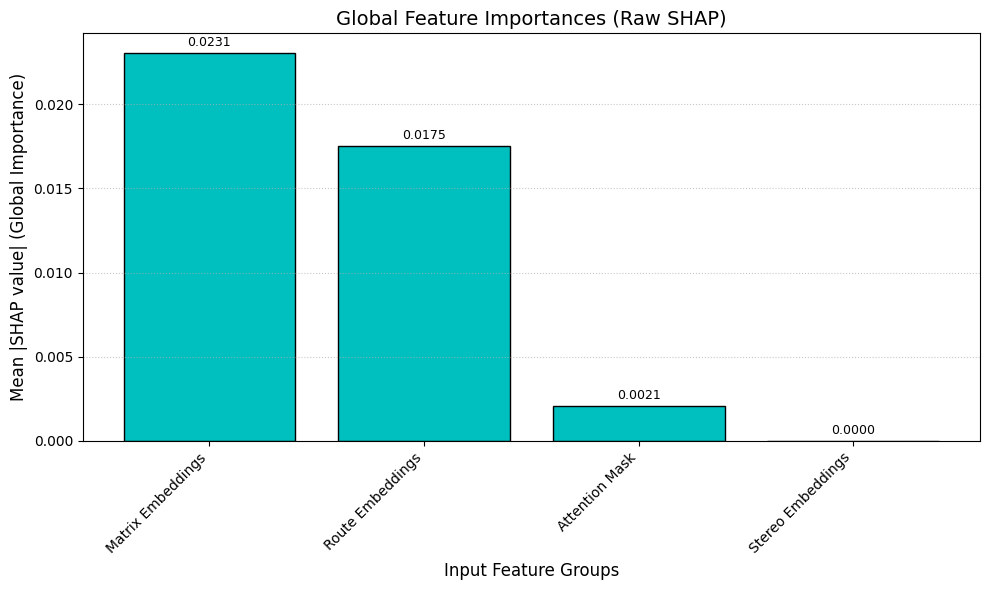

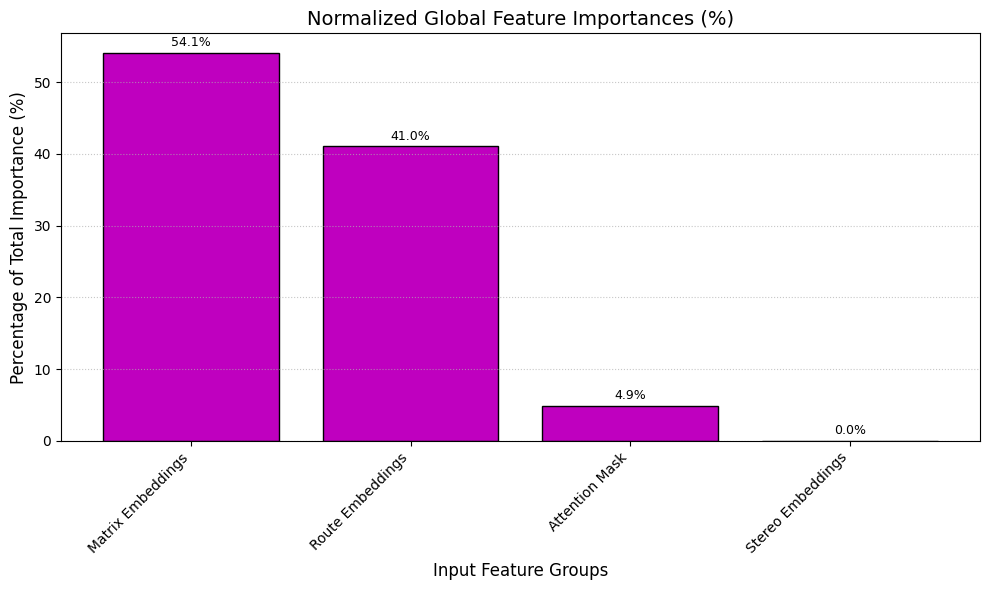

In [55]:
# GLOBAL IMPORTANCE PLOTTING
# Use the dictionary created in the previous block
if 'global_importance_dict' in locals() and global_importance_dict:
    names_plot = list(global_importance_dict.keys())
    raw_imp_plot = np.array(list(global_importance_dict.values()))

    sorted_indices_plot = np.argsort(raw_imp_plot)[::-1]
    sorted_names_plot = [names_plot[i] for i in sorted_indices_plot]
    sorted_raw_imp_plot = raw_imp_plot[sorted_indices_plot]

    plt.figure(figsize=(10, 6)) # Adjusted size
    bars_raw = plt.bar(sorted_names_plot, sorted_raw_imp_plot, color='c', edgecolor='k')
    plt.ylabel("Mean |SHAP value| (Global Importance)", fontsize=12)
    plt.xlabel("Input Feature Groups", fontsize=12)
    plt.xticks(rotation=45, ha="right", fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Global Feature Importances (Raw SHAP)", fontsize=14)
    for bar in bars_raw:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + (0.01 * np.max(sorted_raw_imp_plot) if np.max(sorted_raw_imp_plot) > 0 else 0.01), f'{yval:.4f}', ha='center', va='bottom', fontsize=9)
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

    if raw_imp_plot.sum() != 0:
        imp_pct_sorted_plot = sorted_raw_imp_plot / raw_imp_plot.sum() * 100
        plt.figure(figsize=(10, 6)) # Adjusted size
        bars_pct = plt.bar(sorted_names_plot, imp_pct_sorted_plot, color='m', edgecolor='k')
        plt.ylabel("Percentage of Total Importance (%)", fontsize=12)
        plt.xlabel("Input Feature Groups", fontsize=12)
        plt.xticks(rotation=45, ha="right", fontsize=10)
        plt.yticks(fontsize=10)
        plt.title("Normalized Global Feature Importances (%)", fontsize=14)
        for bar in bars_pct:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.5 , f'{yval:.1f}%', ha='center', va='bottom', fontsize=9)
        plt.grid(axis='y', linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.show()
    else:
        print("Sum of raw importances is zero. Skipping percentage plot.")
else:
    print("Warning: 'global_importance_dict' is empty or not defined. Cannot generate global importance plots.")

In [57]:
import os

# TOKEN IMPORTANCE VISUALIZATION
# ==============================

# --- Use the most complete visualize_molecule_importance definition (the one using rdMolDraw2D) ---

# --- Generate Summary Plot (assumes generate_summary_plot and test_smiles are defined correctly) ---
if 'analyzed_token_importances' in locals() and analyzed_token_importances is not None and analyzed_token_importances.size > 0:
    if 'analyzed_test_smiles' in locals() and analyzed_test_smiles: # Ensure test_smiles for generate_summary_plot
         # Definition of generate_summary_plot must be available
         # It needs test_smiles to link tokens back to their original SMILES for aggregation
         # Assuming test_smiles used by generate_summary_plot is `analyzed_test_smiles`
         # generate_summary_plot(analyzed_token_importances, tokenizer, test_smiles=analyzed_test_smiles, top_n=20)
         print("Skipping generate_summary_plot for now as its `test_smiles` dependency needs to be confirmed.")
    else:
        print("`analyzed_test_smiles` not available for `generate_summary_plot`.")

    # --- Visualize individual molecules using the rdMolDraw2D version ---
    output_directory = "/content/drive/MyDrive/LLM" # Ensure this directory exists
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)
        print(f"Created directory: {output_directory}")

    num_visualize = min(5, len(analyzed_test_smiles)) # Visualize up to 5 or available
    if num_visualize > 0:
        print(f"\nVisualizing token importances for the first {num_visualize} test SMILES...")
    for i in range(num_visualize):
        current_smiles_to_viz = analyzed_test_smiles[i]
        # Pass the scores for the i-th molecule from `analyzed_token_importances`
        # The `visualize_molecule_importance` function you provided later takes token_imp and an idx.
        # So, we pass `analyzed_token_importances` and `idx=i`.

        print(f"Visualizing molecule {i+1}: {current_smiles_to_viz}")
        output_filename = os.path.join(output_directory, f"molecule_shap_importance_{i+1}.png")

        # Call the RDKit drawing version of visualize_molecule_importance
        # Ensure this function is defined correctly using rdMolDraw2D
        try:
            visualize_molecule_importance( # This should be your rdMolDraw2D version
                smiles=current_smiles_to_viz,
                token_imp=analyzed_token_importances, # Pass the whole array
                tokenizer=tokenizer,
                idx=i,                          # Specify which molecule's scores from the array
                output_file=output_filename
            )
        except Exception as e:
            print(f"Error during molecule visualization for {current_smiles_to_viz}: {e}")
else:
    print("Token importances (`analyzed_token_importances`) not available for visualization.")

Skipping generate_summary_plot for now as its `test_smiles` dependency needs to be confirmed.

Visualizing token importances for the first 5 test SMILES...
Visualizing molecule 1: C1=CN=C(N=C1)NS(=O)(=O)C2=CC=C(C=C2)N
Error during molecule visualization for C1=CN=C(N=C1)NS(=O)(=O)C2=CC=C(C=C2)N: name 'visualize_molecule_importance' is not defined
Visualizing molecule 2: CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C(C=CC(=C41)Cl)O)O)O)O)C(=O)N)N(C)C)O
Error during molecule visualization for CC1(C2CC3C(C(=O)C(=C(C3(C(=O)C2=C(C4=C(C=CC(=C41)Cl)O)O)O)O)C(=O)N)N(C)C)O: name 'visualize_molecule_importance' is not defined
Visualizing molecule 3: CC1=C(C(=NC(=N1)NS(=O)(=O)C2=CC=C(C=C2)N)C)CCS(=O)(=O)O
Error during molecule visualization for CC1=C(C(=NC(=N1)NS(=O)(=O)C2=CC=C(C=C2)N)C)CCS(=O)(=O)O: name 'visualize_molecule_importance' is not defined
Visualizing molecule 4: CCC1C(C=C(C=CC(=O)C(CC(C(C(C(CC(=O)O1)O)C)OC2C(C(C(C(O2)C)O)N(C)C)O)CCN3CCCCC3)C)C)CN4CCCCC4
Error during molecule visualization fo

In [61]:
# AD HELPER FUNCTION DEFINITIONS
# ===============================
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler # Needed for eval_ad
import matplotlib.pyplot as plt # Needed for plot_williams

# Definition for make_stereo_indices (needed by extract_features_and_preds)
def make_stereo_indices(input_ids, tokenizer):
    # ... (definition as provided before) ...
    slash_id     = tokenizer.convert_tokens_to_ids('/')
    backslash_id = tokenizer.convert_tokens_to_ids('\\')
    at_id        = tokenizer.convert_tokens_to_ids('@')
    si = torch.zeros_like(input_ids)
    si[input_ids == slash_id]     = 1
    si[input_ids == backslash_id] = 2
    si[input_ids == at_id]        = 3
    return si

# Definition for ChemDatasetEval (needed by extract_features_and_preds)
class ChemDatasetEval(torch.utils.data.Dataset):
    # ... (definition as provided before) ...
    def __init__(self, df, tokenizer, route_enc, matrix_enc, target_col):
        self.smiles     = df['SMILES'].tolist()
        self.targets    = df[target_col].values.astype(float)
        self.route      = torch.tensor(route_enc.transform(df['Route']),  dtype=torch.long)
        self.matrix     = torch.tensor(matrix_enc.transform(df['Matrix']), dtype=torch.long)
        self.encodings  = tokenizer(
            df['SMILES'].tolist(),
            padding='max_length',
            truncation=True,
            max_length=256,
            return_tensors='pt'
        )
    def __len__(self):
        return len(self.smiles)
    def __getitem__(self, i):
        return {
            'input_ids':      self.encodings['input_ids'][i],
            'attention_mask': self.encodings['attention_mask'][i],
            'route':          self.route[i],
            'matrix':         self.matrix[i],
            'label':          torch.tensor(self.targets[i], dtype=torch.float),
            'smiles':         self.smiles[i]
        }


# Definition for extract_features_and_preds
def extract_features_and_preds(model, df, tokenizer, route_enc, matrix_enc, device):
    # ... (definition as provided before) ...
    ds     = ChemDatasetEval(df, tokenizer, route_enc, matrix_enc, 'LambdaZHl_scaled')
    loader = DataLoader(ds, batch_size=32, shuffle=False)
    model.eval()
    all_feats, all_preds, all_trues = [], [], []
    with torch.no_grad():
        for batch in loader:
            ids   = batch['input_ids'].to(device)
            mask  = batch['attention_mask'].to(device)
            rt    = batch['route'].to(device)
            mx    = batch['matrix'].to(device)
            lbl   = batch['label'].to(device)
            out = model.chemberta(input_ids=ids, attention_mask=mask).last_hidden_state
            wts = model.attention(out)
            chem_pooled = (out * wts).sum(dim=1)
            route_e  = model.route_embed(rt)
            matrix_e = model.matrix_embed(mx)
            stereo_idx = make_stereo_indices(ids, tokenizer).to(device)
            stereo_e   = model.stereo_embed(stereo_idx).mean(dim=1)
            combined_features_for_ad = torch.cat([chem_pooled, route_e, matrix_e, stereo_e], dim=1)
            all_feats.append(combined_features_for_ad.cpu().numpy())
            preds = model(input_ids=ids, attention_mask=mask, route=rt, matrix=mx).squeeze()
            all_preds.append(preds.cpu().numpy())
            all_trues.append(lbl.cpu().numpy())
    X_features  = np.vstack(all_feats)
    y_predictions = np.concatenate(all_preds)
    y_true_labels = np.concatenate(all_trues)
    return X_features, y_true_labels, y_predictions


# --- Definitions for hat_matrix, eval_ad, and plot_williams (from Search Result [1]) ---
def hat_matrix(X, random_seed=None): # random_seed for jitter was in the search result
    if random_seed is not None: # Check if random_seed is provided
        np.random.seed(random_seed)
    xtx = X.T @ X
    # Jitter to ensure invertibility, as shown in the search result
    # The range of jitter might need adjustment based on the scale of your X features.
    jitter_scale = (np.diag(xtx).mean() * 1e-6) if xtx.shape[0] > 0 and np.diag(xtx).mean() > 0 else 1e-6
    jitter = np.random.uniform(jitter_scale * 0.1, jitter_scale, size=xtx.shape[0])
    np.fill_diagonal(xtx, np.diagonal(xtx) + jitter)

    try:
        ixtx = np.linalg.pinv(xtx) # Use pseudo-inverse for stability
    except np.linalg.LinAlgError:
        print("Warning: Singular matrix in hat_matrix. Using identity as fallback for ixtx (this is not ideal).")
        ixtx = np.eye(xtx.shape[0]) # Fallback, but indicates issues with X features (e.g. collinearity)
    return X @ ixtx @ X.T

def eval_ad(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):
    # standardize features
    scaler = StandardScaler() # Make sure StandardScaler is imported
    Xtr = scaler.fit_transform(X_train)
    Xte = scaler.transform(X_test)

    # build hat-matrix over [train;test]
    # The original code did not specify a random_seed for hat_matrix here,
    # but it might be good for reproducibility if jitter is significant.
    H = hat_matrix(np.vstack([Xtr, Xte]), random_seed=42) # Added a seed for reproducibility
    lev_tr = np.diag(H)[:len(Xtr)]
    lev_te = np.diag(H)[len(Xtr):]

    # standardized residuals
    res_tr  = np.abs(y_train - y_pred_train)
    res_te  = np.abs(y_test  - y_pred_test)

    # Handle cases where standard deviation might be zero (e.g., if all residuals are the same)
    s_tr = np.zeros_like(res_tr)
    if res_tr.std() > 1e-9: # Check for non-zero std dev
        s_tr    = (res_tr - res_tr.mean()) / res_tr.std()
    else:
        print("Warning: Standard deviation of training residuals is close to zero.")

    s_te = np.zeros_like(res_te)
    if res_te.std() > 1e-9: # Check for non-zero std dev
        s_te    = (res_te - res_te.mean()) / res_te.std()
    else:
        print("Warning: Standard deviation of test residuals is close to zero.")


    # leverage cutoff
    p      = X_train.shape[1] + 1 # Number of model parameters (features + intercept)
    n      = len(Xtr) + len(Xte)  # Total number of samples
    if n == 0: # Prevent division by zero if no samples
        print("Warning: No samples to calculate h_star.")
        h_star = np.inf
    else:
        h_star = (3 * p) / n

    # % in-domain
    AD_tr = ((lev_tr < h_star) & (np.abs(s_tr) < 3)).mean() * 100 if len(lev_tr) > 0 else 0
    AD_te = ((lev_te < h_star) & (np.abs(s_te) < 3)).mean() * 100 if len(lev_te) > 0 else 0

    return AD_tr, AD_te, s_tr, s_te, lev_tr, lev_te, h_star

def plot_williams(lev_tr, s_tr, lev_te, s_te, h_star):
    plt.figure(figsize=(8,6)) # Make sure plt is imported (matplotlib.pyplot)
    plt.scatter(lev_tr, s_tr, c='blue', alpha=0.6, label=f'Train ({len(lev_tr)} points)')
    plt.scatter(lev_te, s_te, c='red',  alpha=0.6, label=f'Test ({len(lev_te)} points)')
    plt.axhline(+3, color='black', linestyle='-', linewidth=1.5, label='Std. Residual Cutoff (±3)')
    plt.axhline(-3, color='black', linestyle='-', linewidth=1.5)
    plt.axvline(h_star, color='darkgreen', linestyle='--', linewidth=1.5, label=f'Leverage Cutoff (h*={h_star:.2f})')
    plt.xlabel("Leverage (h)", fontsize=12)
    plt.ylabel("Standardized Residuals", fontsize=12)
    plt.title("Williams Plot (Applicability Domain)", fontsize=14)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    plt.show()



--- Starting Applicability Domain (AD) Analysis ---
Using the same model that was (or was intended for) SHAP analysis.
Extracting features for AD training set...
Extracting features for AD test set...
Evaluating AD...
AD training-set in-domain: 99.1%
AD test-set in-domain: 98.7%


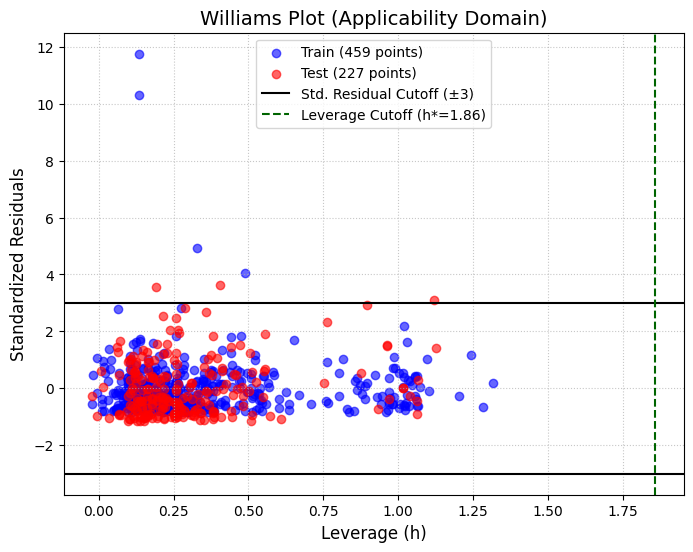

In [62]:
# APPLICABILITY DOMAIN (AD) ANALYSIS
# ==================================
if 'model_to_analyze_with_shap' in locals() and model_to_analyze_with_shap is not None:
    print("\n--- Starting Applicability Domain (AD) Analysis ---")
    print("Using the same model that was (or was intended for) SHAP analysis.")

    # Ensure 'train_df' and 'test_df' are your pandas DataFrames with the necessary columns
    # Ensure 'tokenizer', 'route_encoder', 'matrix_encoder' are defined and are the correct fitted instances

    device_ad = next(model_to_analyze_with_shap.parameters()).device

    print("Extracting features for AD training set...")
    X_tr_ad, y_tr_ad, yp_tr_ad = extract_features_and_preds(
        model_to_analyze_with_shap, train_df, tokenizer, route_encoder, matrix_encoder, device_ad
    )
    print("Extracting features for AD test set...")
    X_te_ad, y_te_ad, yp_te_ad = extract_features_and_preds(
        model_to_analyze_with_shap, test_df,  tokenizer, route_encoder, matrix_encoder, device_ad
    )

    print("Evaluating AD...")
    # Now eval_ad should be defined
    AD_tr_percent, AD_te_percent, s_tr_ad, s_te_ad, lev_tr_ad, lev_te_ad, h_star_ad = eval_ad(
        X_tr_ad, X_te_ad, y_tr_ad, y_te_ad, yp_tr_ad, yp_te_ad
    )

    print(f"AD training-set in-domain: {AD_tr_percent:.1f}%")
    print(f"AD test-set in-domain: {AD_te_percent:.1f}%")

    # Now plot_williams should be defined
    plot_williams(lev_tr_ad, s_tr_ad, lev_te_ad, s_te_ad, h_star_ad)
else:
    print("Error: No model available for Applicability Domain analysis (expected 'model_to_analyze_with_shap').")

